# Categorical/Softmax Regression/Classification of IRIS data set

- For ML estimation, see Logistic Regression in [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
    - page 144 of the pdf
- For Full Bayesian MCMC, see 
        - Chapter 5: Classifying Outcomes with Logistic Regression, in Bayesian Analysis with Python by Osvaldo Martin.
            - with PyMC3.

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
#sns.set_style("darkgrid");
plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# plt.style.use("dark_background")

In [2]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]
    mad = np.median(np.abs(v-med))
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print(' Med MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f} {mad_sd:+5.3f}')

In [3]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

Load IRIS dataset.

In [4]:
iris = sns.load_dataset('iris')  # pandas DataFrame
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


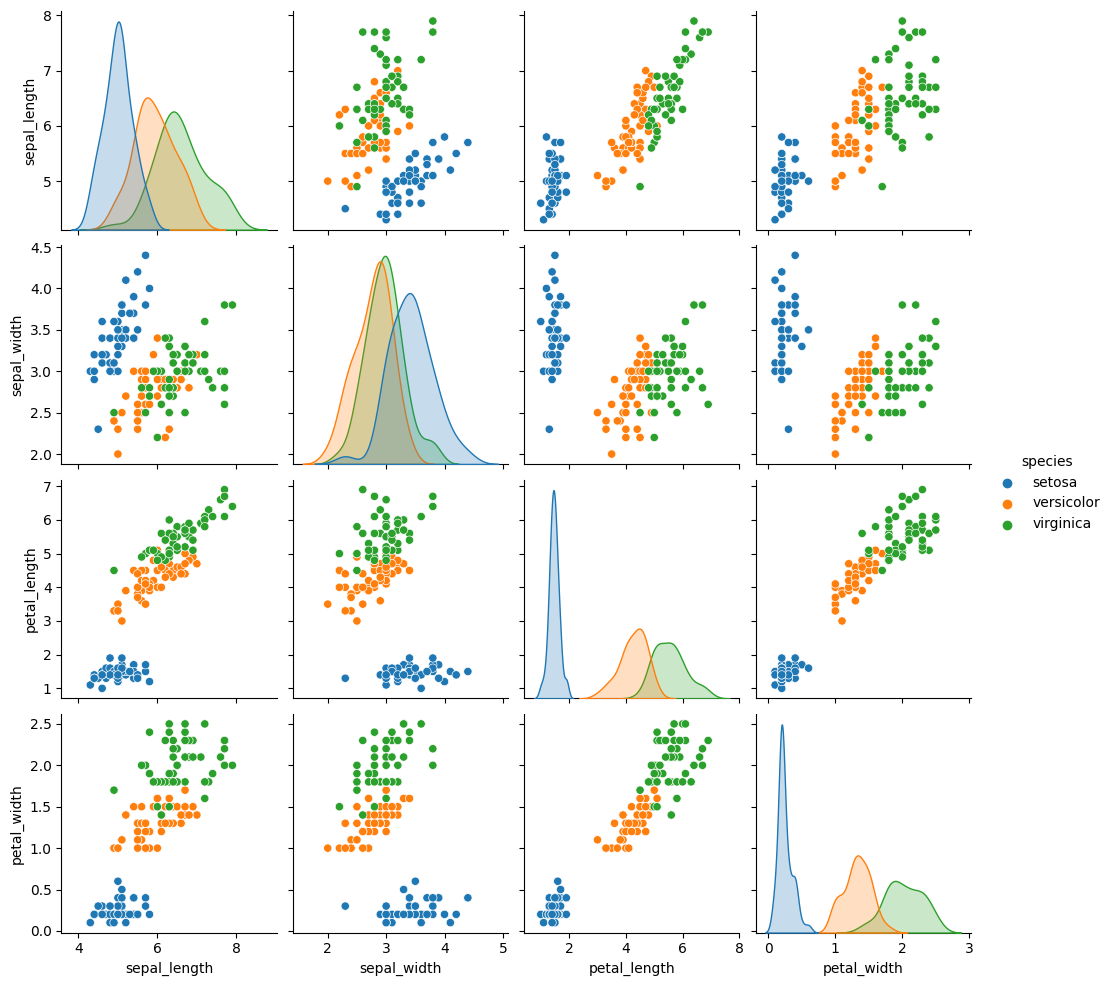

In [5]:
sns.pairplot(iris, hue='species');

In [6]:
feature_names = iris.columns[:-1]
print('feature_names: ', feature_names)
x = iris[feature_names].values
x[:3]

feature_names:  Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [7]:
iris['species'] = iris['species'].astype('category')
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [8]:
y = iris.species.cat.codes.values  # as 'category' data type in pandas, this comes conveniently.
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [9]:
iris.species.cat.codes.unique()  # we have three unique species as verified by this command.

array([0, 1, 2], dtype=int8)

# Logistic regression for binary classification 
- Two species only: setosa vs versicolor
- Only one feature: the sepal length

In [10]:
df = iris[(iris.species == 'setosa')  | (iris.species == 'versicolor')]
df.tail(3)

,sepal_length,sepal_width,petal_length,petal_width,species
97,6.2,2.9,4.3,1.3,versicolor
98,5.1,2.5,3.0,1.1,versicolor
99,5.7,2.8,4.1,1.3,versicolor


Prepare data for numpyro inference.

In [11]:
x_name = 'sepal_length'
x = df[x_name].values  # training data
y = df.species.cat.codes.values  # training target
x, y

(array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8))

## Make a generative model

$$
    \theta = logistic(a + b x) \\
    y \sim \mathrm{Bern}(\theta)
$$

In [12]:
def model(x, y=None):
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))
    
    with numpyro.plate('N', size=x.shape[0]):  # for each observation
        t = a + b * x
        theta = numpyro.deterministic('theta',  1. / ( 1 + jnp.exp(-t)) )
        bd = numpyro.deterministic('bd', -a / b)  # decision boundary
        obs = numpyro.sample('y', 
                             dist.Bernoulli(probs=theta),
                             obs = y)

## Do Inference

In [13]:
def mcmcinf(model, args):
    # args: dict for model input arguments
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
    #
    mcmc.run(rngkey, **args)
    mcmc.print_summary(exclude_deterministic=True, prob=.8)
    return mcmc

In [14]:
args = dict(x=x, y=y)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:11<00:00, 959.97it/s, 7 steps of size 5.36e-02. acc. prob=0.94]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
         a    -23.25      4.05    -23.11    -27.76    -17.60   1590.08      1.00
         b      4.29      0.75      4.27      3.24      5.12   1589.06      1.00

Number of divergences: 0


In [15]:
trace = mcmc.get_samples()
trace

{'a': DeviceArray([-17.705627, -16.388163, -16.989265, ..., -22.862135,
              -25.390533, -25.542667], dtype=float32),
 'b': DeviceArray([3.2986245, 3.0921428, 3.0643728, ..., 4.1931725, 4.71299  ,
              4.6676445], dtype=float32),
 'bd': DeviceArray([5.367579 , 5.2999372, 5.544125 , ..., 5.4522285, 5.3873515,
              5.472282 ], dtype=float32),
 'theta': DeviceArray([[0.29263043, 0.17619145, 0.0995627 , ..., 0.9396782 ,
               0.29263043, 0.74960965],
              [0.3501831 , 0.22501747, 0.13527615, ..., 0.94175696,
               0.3501831 , 0.7750503 ],
              [0.20408359, 0.12197718, 0.06999839, ..., 0.88182694,
               0.20408359, 0.6171949 ],
              ...,
              [0.18588768, 0.08984005, 0.04092512, ..., 0.95833486,
               0.18588768, 0.7386468 ],
              [0.20517057, 0.09138145, 0.03770667, ..., 0.9787517 ,
               0.20517057, 0.8135899 ],
              [0.14960775, 0.06469379, 0.02647457, ..., 0.9676

In [16]:
trace['theta'] = np.expand_dims(trace['theta'], 0)
trace['theta'].shape

(1, 10000, 100)

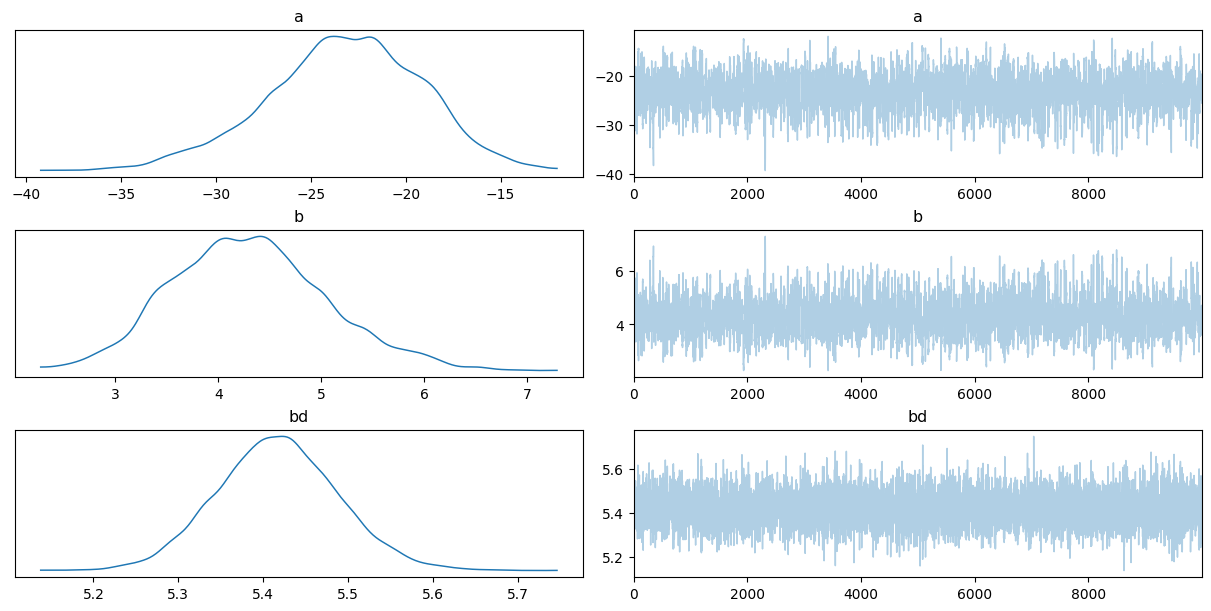

In [17]:
import arviz
arviz.plot_trace(trace, var_names=['a', 'b', 'bd']);

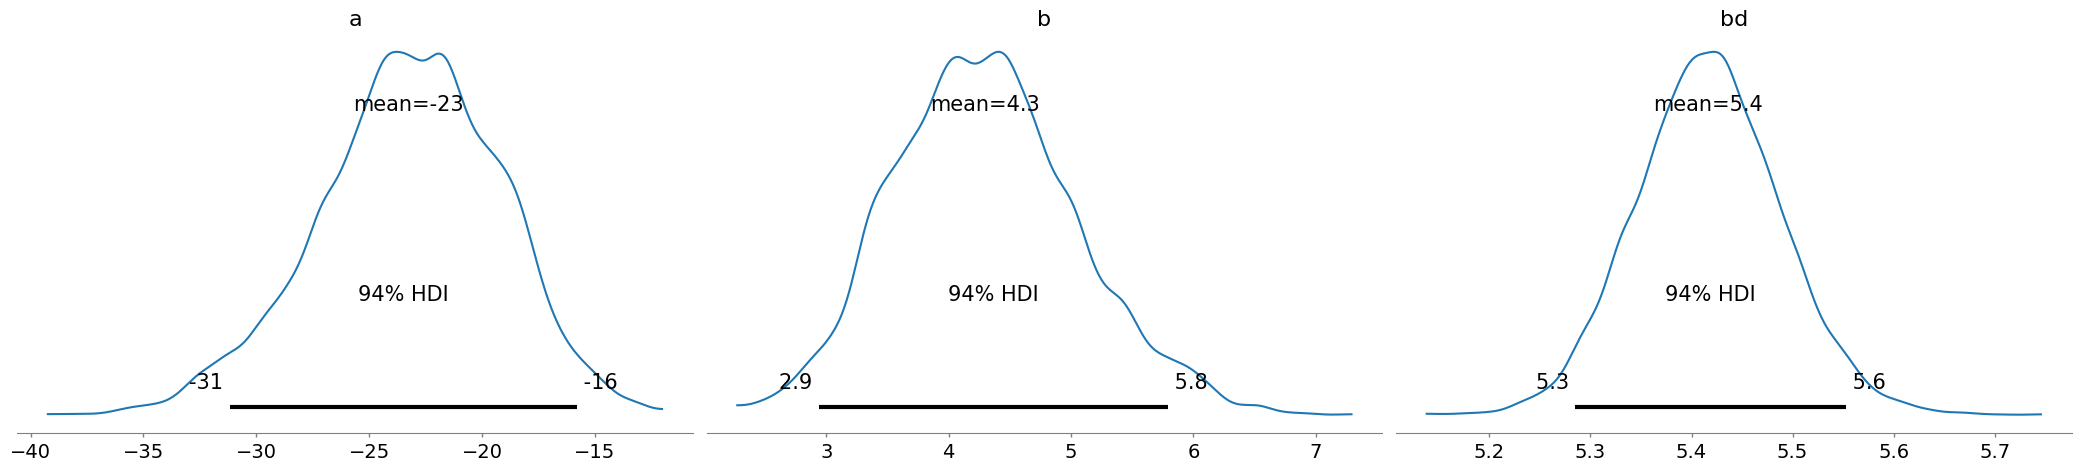

In [18]:
arviz.plot_posterior(trace, var_names=['a', 'b', 'bd']);

In [19]:
thpd = numpyro.diagnostics.hpdi(trace['theta'][0])
thpd.shape

(2, 100)

argsort(x):  [13 42 38  8 41  3  6 47 22  2 29 24 45 11 30 12 57  9 37  1 34 40 26 25
 49 35 60  7 93  4 43 44 98 39 46  0 19 23 21 17 32 28 27 59 48 10 16  5
 20 31 84 89 53 36 81 33 90 80 69 94 64 88 66 79 95 96 99 18 15 55 67 92
 82 14 70 61 85 78 83 62 63 73 71 91 97 68 56 87 72 74 51 54 75 58 77 86
 65 76 52 50]
x:  [5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5.  7.  6.4 6.9 5.5
 6.5 5.7 6.3 4.9 6.6 5.2 5.  5.9 6.  6.1 5.6 6.7 5.6 5.8 6.2 5.6 5.9 6.1
 6.3 6.1 6.4 6.6 6.8 6.7 6.  5.7 5.5 5.5 5.8 6.  5.4 6.  6.7 6.3 5.6 5.5
 5.5 6.1 5.8 5.  5.6 5.7 5.7 6.2 5.1 5.7]
x= 4.7 hpdi= [0.01061337 0.09015132]


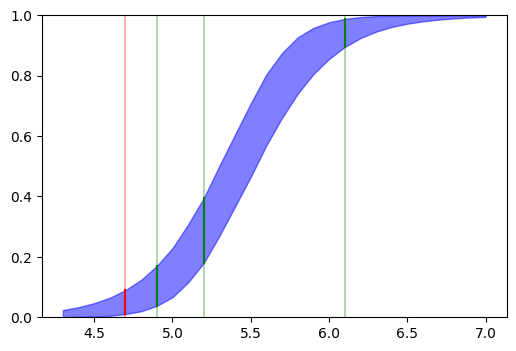

In [20]:
idx = np.argsort(x)
print('argsort(x): ', idx,)
print('x: ', x)
thpd = numpyro.diagnostics.hpdi(trace['theta'][0]).T[idx]
plt.fill_between(x[idx], thpd[:,0], thpd[:,1], color='b', alpha=0.5, )
i=10
ii = idx[i]
plt.axvline(x=x[ii], color='r', alpha=.3);
plt.axvline(x=x[ii], ymin=thpd[i,0], ymax=thpd[i,1], color='r');  # ylim dependent. Strange.
plt.ylim([0,1])
print('x=', x[ii], 'hpdi=', thpd[i])
for i in [20, 40, 80]:
    ii = idx[i]
    plt.axvline(x=x[ii], color='g', alpha=.3);
    plt.axvline(x=x[ii], ymin=thpd[i,0], ymax=thpd[i,1], color='g');

Above figure: 
- The blue line may be interpreted as the probability of a flower being versicolor given that we know the value of the `sepal length` or $p(y=1|x)$.
- The semi-transparent blue band is the 95% HDI (HPDI).

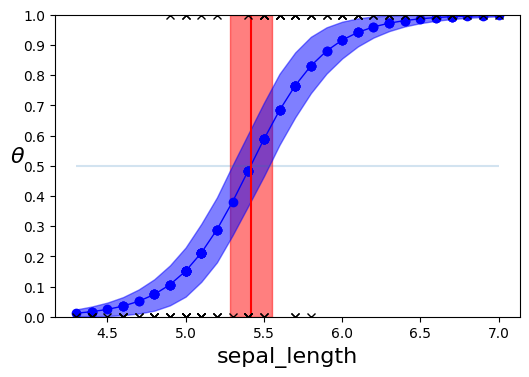

In [21]:
theta = trace['theta'][0].mean(axis=0)
idx = np.argsort(x)

plt.plot(x[idx], theta[idx], '-o', color='b', lw=1);  # mean of theta for each x
plt.axvline(trace['bd'].mean(), ymax=1, color='r')    # decision boundary line

bd_hpd = numpyro.diagnostics.hpdi(trace['bd'], prob=0.94)   # high density interval for decision boundary
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)  

plt.plot(x, y, 'x', color='k')  # data points

theta_hpd = numpyro.diagnostics.hpdi(trace['theta'][0]).T[idx]
plt.fill_between(x[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.ylim([0, 1])
plt.yticks(ticks=np.linspace(0,1,11)); plt.hlines(y=.5, xmin=x[idx[0]], xmax=x[idx[-1]], alpha=.2)
plt.xlabel(x_name, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16);

## Making Predictions

In [22]:
args = dict(x=x, y=y)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:11<00:00, 962.68it/s, 7 steps of size 5.36e-02. acc. prob=0.94]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
         a    -23.25      4.05    -23.11    -27.76    -17.60   1590.08      1.00
         b      4.29      0.75      4.27      3.24      5.12   1589.06      1.00

Number of divergences: 0


In [23]:
predictive = Predictive(model, posterior_samples=mcmc.get_samples())

In [24]:
x

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7])

In [25]:
rng_key=jax.random.PRNGKey(0)
pred = predictive(rng_key=jax.random.PRNGKey(0), x=x)

In [26]:
pred

{'bd': DeviceArray([5.367579 , 5.2999372, 5.544125 , ..., 5.4522285, 5.3873515,
              5.472282 ], dtype=float32),
 'theta': DeviceArray([[0.29263043, 0.17619145, 0.0995627 , ..., 0.9396782 ,
               0.29263043, 0.74960965],
              [0.3501831 , 0.22501747, 0.13527615, ..., 0.94175696,
               0.3501831 , 0.7750503 ],
              [0.20408359, 0.12197718, 0.06999839, ..., 0.88182694,
               0.20408359, 0.6171949 ],
              ...,
              [0.18588768, 0.08984005, 0.04092512, ..., 0.95833486,
               0.18588768, 0.7386468 ],
              [0.20517057, 0.09138145, 0.03770667, ..., 0.9787517 ,
               0.20517057, 0.8135899 ],
              [0.14960775, 0.06469379, 0.02647457, ..., 0.9676021 ,
               0.14960775, 0.7432454 ]], dtype=float32),
 'y': DeviceArray([[0, 0, 0, ..., 1, 0, 1],
              [0, 0, 0, ..., 1, 0, 1],
              [0, 0, 0, ..., 1, 0, 0],
              ...,
              [1, 0, 0, ..., 1, 0, 0],
     

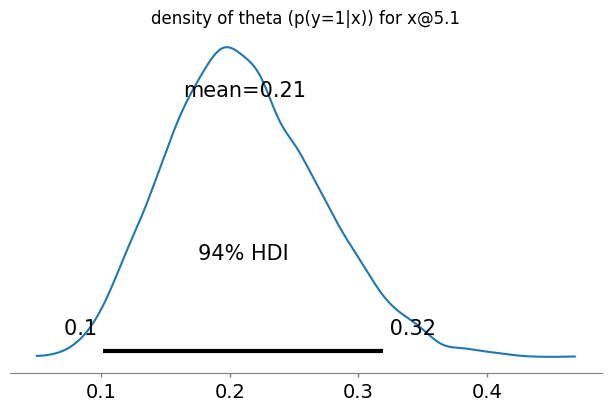

In [27]:
# first x
i = 0
ax = arviz.plot_posterior(np.array(pred['theta'][:,i]), );
ax.set(title=f'density of theta (p(y=1|x)) for x@{x[i]}');

In [28]:
ypred = pred['y']
ypred.shape

(10000, 100)

In [29]:
ypred.sum(axis=0)

DeviceArray([2166, 1033,  480,  351, 1492, 4822,  339, 1500,  164, 1014,
             4763,  701,  739,  114, 8274, 7667, 4827, 2138, 7746, 2132,
             4802, 2140,  327, 2006,  696, 1544, 1468, 2975, 2909,  507,
              724, 4834, 2876, 5952, 1050, 1606, 5811, 1050,  154, 2108,
             1542,  268,  169, 1505, 2118,  691, 2114,  344, 3850, 1516,
             9982, 9815, 9972, 5963, 9870, 7600, 9702, 1019, 9918, 2884,
             1473, 8812, 9152, 9429, 6829, 9927, 6840, 8290, 9617, 6716,
             8753, 9396, 9698, 9427, 9815, 9892, 9959, 9931, 9170, 7700,
             5834, 5843, 8282, 9096, 4858, 9085, 9946, 9742, 6807, 5803,
             5781, 9406, 8415, 1557, 6818, 7664, 7667, 9574, 2135, 7681],            dtype=int32)

In [31]:
ypred.mean(axis=0)

DeviceArray([0.2166, 0.1033, 0.048 , 0.0351, 0.1492, 0.4822, 0.0339,
             0.15  , 0.0164, 0.1014, 0.4763, 0.0701, 0.0739, 0.0114,
             0.8274, 0.7667, 0.4827, 0.2138, 0.7746, 0.2132, 0.4802,
             0.214 , 0.0327, 0.2006, 0.0696, 0.1544, 0.1468, 0.2975,
             0.2909, 0.0507, 0.0724, 0.4834, 0.2876, 0.5952, 0.105 ,
             0.1606, 0.5811, 0.105 , 0.0154, 0.2108, 0.1542, 0.0268,
             0.0169, 0.1505, 0.2118, 0.0691, 0.2114, 0.0344, 0.385 ,
             0.1516, 0.9982, 0.9815, 0.9972, 0.5963, 0.987 , 0.76  ,
             0.9702, 0.1019, 0.9918, 0.2884, 0.1473, 0.8812, 0.9152,
             0.9429, 0.6829, 0.9927, 0.684 , 0.829 , 0.9617, 0.6716,
             0.8753, 0.9396, 0.9698, 0.9427, 0.9815, 0.9892, 0.9959,
             0.9931, 0.917 , 0.77  , 0.5834, 0.5843, 0.8282, 0.9096,
             0.4858, 0.9085, 0.9946, 0.9742, 0.6807, 0.5803, 0.5781,
             0.9406, 0.8415, 0.1557, 0.6818, 0.7664, 0.7667, 0.9574,
             0.2135, 0.7681], dtyp

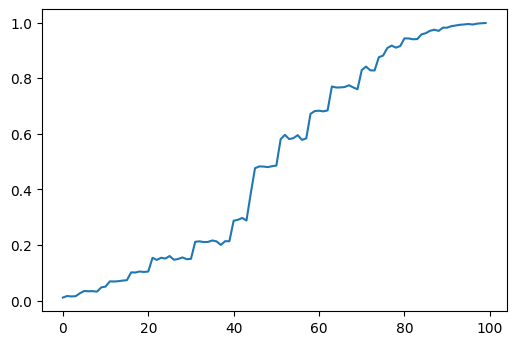

In [32]:
plt.plot(ypred.mean(axis=0)[idx]);

In [33]:
predictive(rng_key=rng_key, x=np.array([4.5555]))

{'bd': DeviceArray([5.367579 , 5.2999372, 5.544125 , ..., 5.4522285, 5.3873515,
              5.472282 ], dtype=float32),
 'theta': DeviceArray([[0.06423938],
              [0.09096524],
              [0.04611014],
              ...,
              [0.02275088],
              [0.01944539],
              [0.01366426]], dtype=float32),
 'y': DeviceArray([[0],
              [1],
              [0],
              ...,
              [0],
              [0],
              [1]], dtype=int32)}

## Warning
- Apply data normalization or standardization and see the result. The model just worked for the dataset, but do not expect such a result in general.

# Logistic Regression with Two Features

- Generative Model

$$
    \theta = logisitic( a + b_1 x_1 + b_2 x_2 ) \\
    y \sim \mathrm{Bernoulli}(\theta)
$$

- Decision Boundary: Now it is a line in $x_0-x_1$ space

$$
    a + b_0 x_0 + b_1 x_1 = 0  \\
    x_1 = - \frac{a}{b_0} - \frac{b_0}{b_1} x_0
$$

In [34]:
def model(x, y=None):
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(1,))
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(2,))  # we need two coefficients
    
    with numpyro.plate('N', size=x.shape[0]):  # observation for-loop
        t = a + jnp.dot(x, b)  # just pretend x is a 4-d row vector (i.e., x[i,:])
        # define theta
        theta = 1. / ( 1. + jnp.exp(-t) )
        bd = -a[0] / b[1] - b[0]*x[:,0]/b[1]
#         print(bd, a[0], b[0], b[1], x[:,0])
        numpyro.deterministic('bd', bd)
        # define observation generation
        numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)

In [35]:
x_names = ['sepal_length', 'sepal_width' ]
x = df[x_names].values  # training data
y = df.species.cat.codes.values  # training target
x[:3], y[:3]

(array([[5.1, 3.5],
        [4.9, 3. ],
        [4.7, 3.2]]),
 array([0, 0, 0], dtype=int8))

In [36]:
mcmc = mcmcinf(model, dict(x=x, y=y))

sample: 100%|██████████| 11000/11000 [00:12<00:00, 884.14it/s, 127 steps of size 4.37e-02. acc. prob=0.93] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]    -14.13      7.15    -14.04    -23.08     -4.79   2860.88      1.00
      b[0]      9.46      2.35      9.22      6.40     12.15   1930.46      1.00
      b[1]    -11.96      3.36    -11.58    -15.35     -7.10   2246.93      1.00

Number of divergences: 13


In [37]:
trace = mcmc.get_samples()
trace

{'a': DeviceArray([[-17.208876],
              [-17.242987],
              [-17.041716],
              ...,
              [-16.999105],
              [-11.768317],
              [-20.529161]], dtype=float32),
 'b': DeviceArray([[  7.22607  ,  -7.217581 ],
              [  7.1361737,  -6.7158856],
              [ 10.427399 , -12.61658  ],
              ...,
              [  8.901535 , -10.120852 ],
              [  7.030219 ,  -8.410129 ],
              [ 12.492344 , -15.49969  ]], dtype=float32),
 'bd': DeviceArray([[2.7216983, 2.5214634, 2.321228 , ..., 3.8229923, 2.7216983,
               3.3224044],
              [2.8516717, 2.6391554, 2.426639 , ..., 4.02051  , 2.8516717,
               3.4892201],
              [2.8643277, 2.6990306, 2.5337338, ..., 3.7734597, 2.8643277,
               3.3602173],
              ...,
              [2.8059611, 2.6300569, 2.4541516, ..., 3.773438 , 2.8059611,
               3.3336759],
              [2.863904 , 2.6967192, 2.5295343, ..., 3.7834187, 2

In [38]:
trace = {k: np.array(v) for k, v in trace.items()}
for k, v in trace.items():
    print(k, v.shape)

a (10000, 1)
b (10000, 2)
bd (10000, 100)


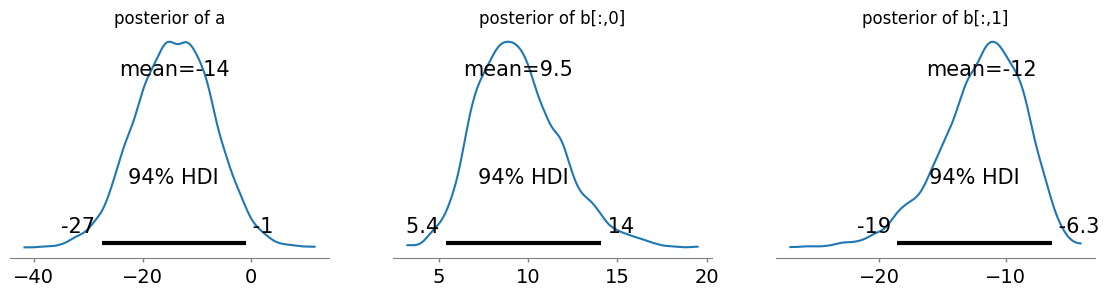

In [39]:
fig, axes = plt.subplots(1,3, figsize=(14,3))
arviz.plot_posterior(trace['a'][:,0], ax=axes[0]);
axes[0].set(title='posterior of a');
for k in range(2):
    arviz.plot_posterior(trace['b'][:,k], ax=axes[k+1]);
    axes[k+1].set(title=f'posterior of b[:,{k}]');

In [40]:
trace['bd'].shape

(10000, 100)

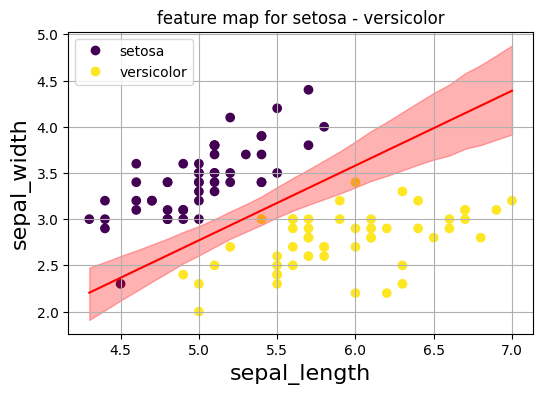

In [41]:
idx = np.argsort(x[:,0])
bd = trace['bd'].mean(0)[idx]

h = plt.scatter(x[:,0], x[:,1], c=y)
plt.plot(x[:,0][idx], bd, color='r'); plt.legend(h.legend_elements()[0], ['setosa', 'versicolor'], loc='upper left')

bd_hpd = numpyro.diagnostics.hpdi(trace['bd'], prob=.94).T[idx]  # high density interval
plt.fill_between(x[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='r', alpha=0.3);

plt.title('feature map for setosa - versicolor')
plt.xlabel(x_names[0], fontsize=16); plt.ylabel(x_names[1], fontsize=16); plt.grid();

# Dealing with unbalanced classes

In [42]:
x.shape

(100, 2)

In [43]:
xu = x[45:]; yu = y[45:]
xu.shape, yu.shape

((55, 2), (55,))

In [44]:
mcmc = mcmcinf(model, dict(x=xu, y=yu))

sample: 100%|██████████| 11000/11000 [00:11<00:00, 973.11it/s, 7 steps of size 8.52e-02. acc. prob=0.71]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     -3.68      9.09     -3.74    -15.75      7.60   1551.76      1.00
      b[0]      8.94      3.09      8.70      4.53     12.28    564.98      1.00
      b[1]    -13.66      5.21    -13.14    -19.02     -6.09    562.18      1.00

Number of divergences: 1680


*NOTE* The MCMC computation was not as stable as before.

- At least, data normalization should be done and see the result.

In [45]:
trace = mcmc.get_samples()

In [46]:
trace = {k: np.array(v) for k, v in trace.items()}
for k, v in trace.items():
    print(k, v.shape)

a (10000, 1)
b (10000, 2)
bd (10000, 55)


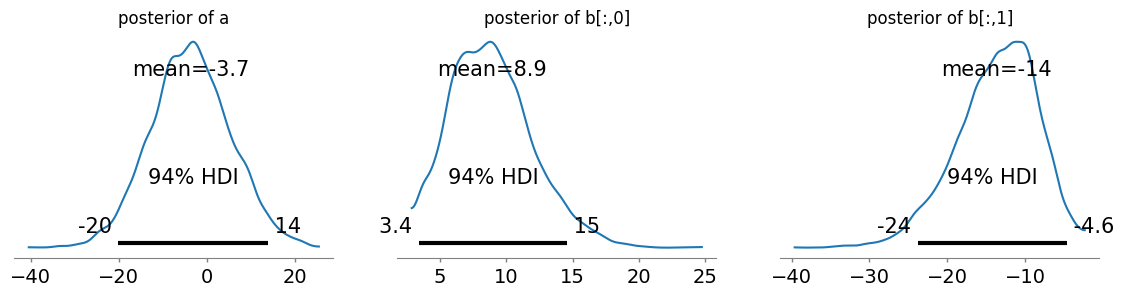

In [47]:
fig, axes = plt.subplots(1,3, figsize=(14,3))
arviz.plot_posterior(trace['a'][:,0], ax=axes[0]);
axes[0].set(title='posterior of a');
for k in range(2):
    arviz.plot_posterior(trace['b'][:,k], ax=axes[k+1]);
    axes[k+1].set(title=f'posterior of b[:,{k}]');

In [48]:
trace['bd'].shape

(10000, 55)

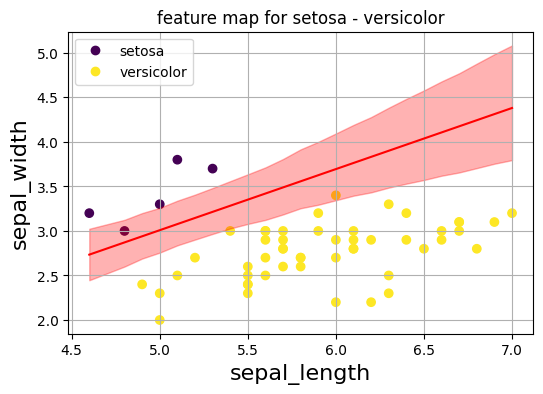

In [49]:
idx = np.argsort(xu[:,0])
bd = trace['bd'].mean(0)[idx]

h = plt.scatter(xu[:,0], xu[:,1], c=yu)
plt.plot(xu[:,0][idx], bd, color='r'); plt.legend(h.legend_elements()[0], ['setosa', 'versicolor'], loc='upper left')

bd_hpd = numpyro.diagnostics.hpdi(trace['bd'], prob=.94).T[idx]  # high density interval
plt.fill_between(xu[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='r', alpha=0.3);

plt.title('feature map for setosa - versicolor')
plt.xlabel(x_names[0], fontsize=16); plt.ylabel(x_names[1], fontsize=16); plt.grid();

## With data normalization

In [50]:
xu = x[45:]; yu = y[45:]
xu.shape, yu.shape

((55, 2), (55,))

In [51]:
xun = xu - xu.mean(axis=0)

In [52]:
mcmc = mcmcinf(model, dict(x=xun, y=yu))

sample: 100%|██████████| 11000/11000 [00:11<00:00, 983.36it/s, 7 steps of size 2.63e-01. acc. prob=0.90]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     10.40      3.51      9.97      5.45     14.06   2141.89      1.00
      b[0]     11.01      4.29     10.50      4.95     15.51   2412.30      1.00
      b[1]    -11.45      4.61    -10.85    -16.39     -5.08   2370.88      1.00

Number of divergences: 0


In [53]:
def model_dn(x, xm, y=None):
    am = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(1,))
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(2,))  # we need two coefficients
    
    with numpyro.plate('N', size=x.shape[0]):  # observation for-loop
        tm = am + jnp.dot(x-xm, b)  # just pretend x is a 4-d row vector (i.e., x[i,:])
        # define theta
        theta = 1. / ( 1. + jnp.exp(-tm) )
        
        # define observation generation
        numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)        
        
        #
        a = am - jnp.dot(xm, b)
        bd = -a[0] / b[1] - b[0]*x[:,0]/b[1]
        numpyro.deterministic('bd', bd)
#

In [54]:
mcmc_dn = mcmcinf(model_dn, dict(x=xu, xm=xu.mean(axis=0), y=yu))

sample: 100%|██████████| 11000/11000 [00:11<00:00, 968.10it/s, 7 steps of size 2.63e-01. acc. prob=0.90]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     10.40      3.51      9.97      5.45     14.06   2141.89      1.00
      b[0]     11.01      4.29     10.50      4.95     15.51   2412.30      1.00
      b[1]    -11.45      4.61    -10.85    -16.39     -5.08   2370.88      1.00

Number of divergences: 0


In [55]:
trace = mcmc_dn.get_samples()

In [56]:
trace = {k: np.array(v) for k, v in trace.items()}
for k, v in trace.items():
    print(k, v.shape)

a (10000, 1)
b (10000, 2)
bd (10000, 55)


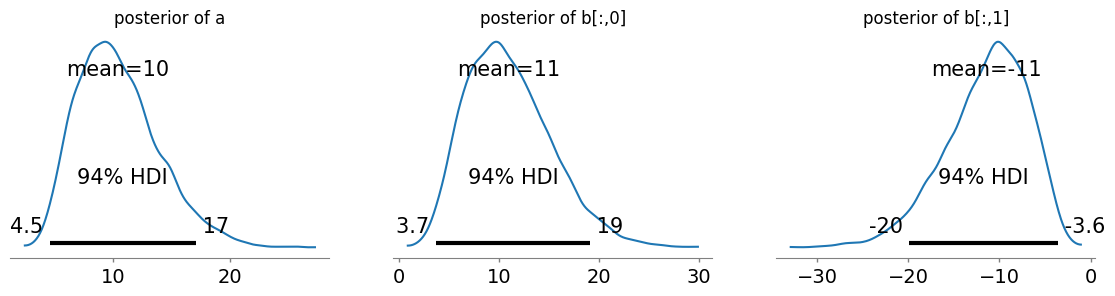

In [57]:
fig, axes = plt.subplots(1,3, figsize=(14,3))
arviz.plot_posterior(trace['a'][:,0], ax=axes[0]);
axes[0].set(title='posterior of a');
for k in range(2):
    arviz.plot_posterior(trace['b'][:,k], ax=axes[k+1]);
    axes[k+1].set(title=f'posterior of b[:,{k}]');

In [58]:
trace['bd'].shape

(10000, 55)

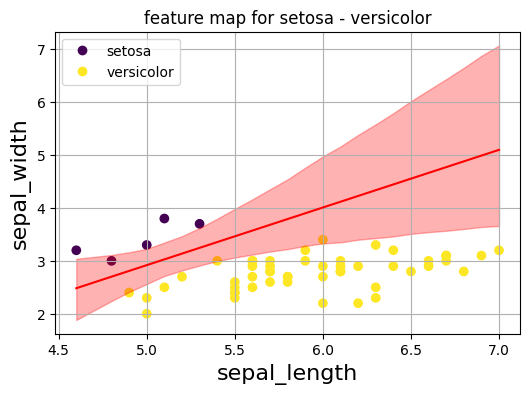

In [59]:
idx = np.argsort(xu[:,0])
bd = trace['bd'].mean(0)[idx]

h = plt.scatter(xu[:,0], xu[:,1], c=yu)
plt.plot(xu[:,0][idx], bd, color='r'); plt.legend(h.legend_elements()[0], ['setosa', 'versicolor'], loc='upper left')

bd_hpd = numpyro.diagnostics.hpdi(trace['bd'], prob=.94).T[idx]  # high density interval
plt.fill_between(xu[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='r', alpha=0.3);

plt.title('feature map for setosa - versicolor')
plt.xlabel(x_names[0], fontsize=16); plt.ylabel(x_names[1], fontsize=16); plt.grid();

- Prepare a balanced dataset
- Be careful when it is unbalanced when you analyse the inference result and make a decision
- Gather and enforce prior information.

### Logistic Regression model
$$
    \log (p/(1-p)) = a + b X
$$

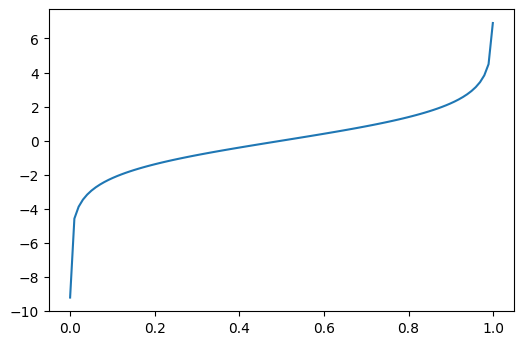

In [60]:
p = np.linspace(.0001, .999, 100)
logit = np.log(p / (1-p))
plt.plot(p, logit)
# plt.plot(p, p / (1-p))

# Logistic Regression with Multiple features

$$
    \theta = logisitic( a + b_1 x_1 + b_2 x_2 + b_3 x_3 + b_4 x_4 ) \\
    y \sim \mathrm{Bernoulli}(\theta)
$$

**do it yourself**

In [61]:
def model(x, y=None):
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(1,))
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(4,))  # we need four coefficients
    
    with numpyro.plate('N', size=x.shape[0]):  # observation for-loop
        t = a + jnp.dot(x, b)  # just pretend x is a 4-d row vector (i.e., x[i,:])
        # define theta
        theta = 1. / ( 1. + jnp.exp(-t) )
        # define observation generation

In [62]:
# and so on so forth

---

# Softmax regression for three class classification, Full Bayesian
- Aka Multinomial logistic regression

In [63]:
iris = sns.load_dataset('iris')  # pandas DataFrame
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


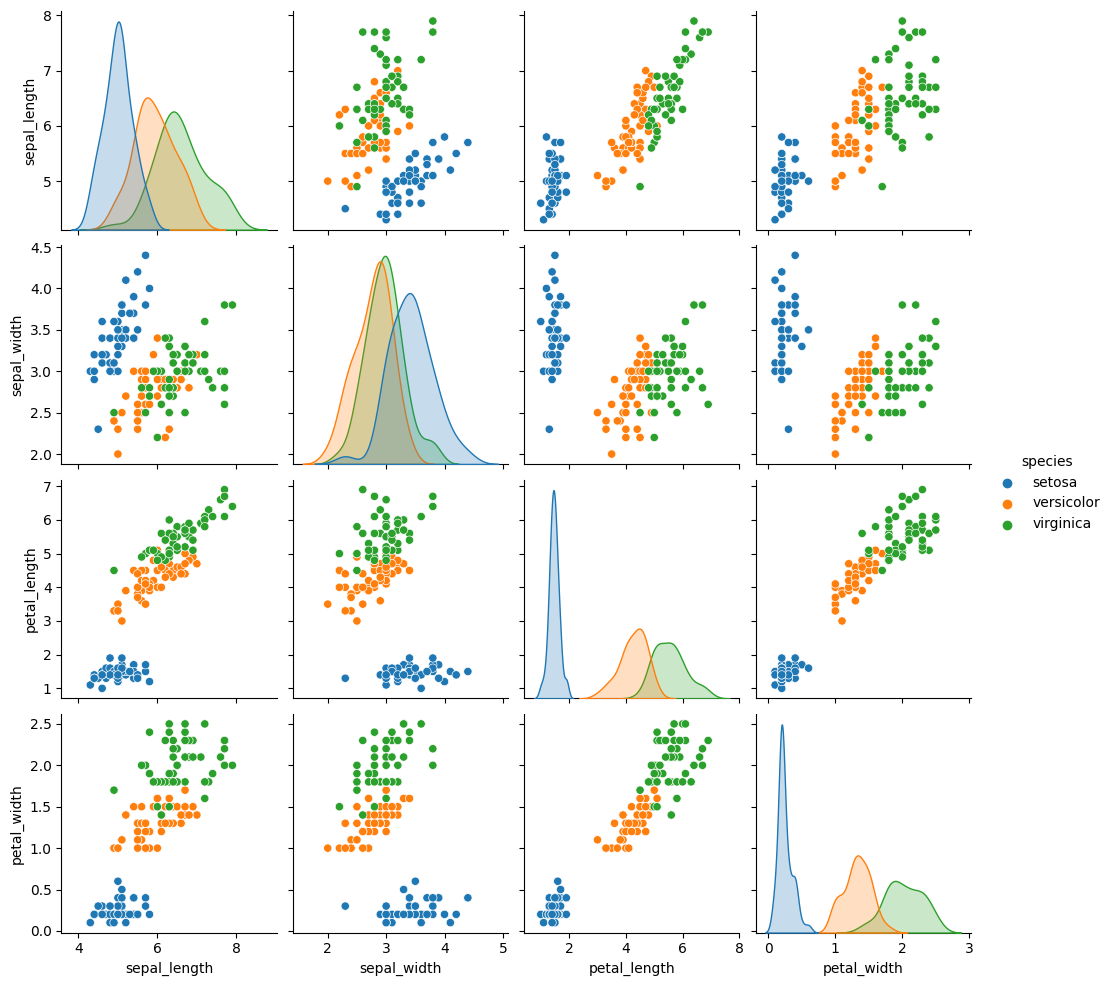

In [64]:
sns.pairplot(iris, hue='species');

In [65]:
feature_names = iris.columns[:-1]
print('feature_names: ', feature_names)
x = iris[feature_names].values
x[:3]

feature_names:  Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [66]:
iris['species'] = iris['species'].astype('category')
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [67]:
y = iris.species.cat.codes.values  # as 'category' data type in pandas, this comes conveniently.
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [68]:
def model(x, y=None):
    # simple linear model
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(3,))  # bias/intercept, three species
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(4,3))
#    print(b.shape)
    
    with numpyro.plate(f'y:{x.shape[0]}', size=x.shape[0]):  ## observation
        t = a + jnp.dot(x, b)
        probs = numpyro.deterministic('probs', jax.nn.softmax(t))  ## probs by softmax
        obs = numpyro.sample('y', dist.Categorical(probs=probs), obs=y)       
#        print(t.shape, obs.shape, probs.shape)

The shape is similar to a small scale neural network. Try to draw a figure to find analogy.

In [69]:
def model_logit(x, y=None):
    # simple linear model
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(3,))  # bias/intercept, three species
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(4,3))
#    print(b.shape)
    
    with numpyro.plate(f'y:{x.shape[0]}', size=x.shape[0]):  ## observation
        t = a + jnp.dot(x, b)
        probs = numpyro.deterministic('probs', jax.nn.softmax(t))  ## probs by softmax
        obs = numpyro.sample('y', dist.Categorical(logits=t), obs=y)       
#        print(t.shape, obs.shape, probs.shape)

## MCMC Inference

In [70]:
def mcmcinf(model, args):
    # args: dict for model input arguments
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
    #
    mcmc.run(rngkey, **args)
    mcmc.print_summary(exclude_deterministic=True, prob=.8)
    return mcmc

In [71]:
args = dict(x=x, y=y)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:29<00:00, 367.20it/s, 266 steps of size 8.95e-03. acc. prob=0.89]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]      2.86      9.86      3.16    -10.08     14.95    920.04      1.00
      a[1]      8.16      8.00      8.26     -2.73     17.97    827.59      1.00
      a[2]    -10.70      7.82    -10.85    -20.57     -0.86    785.89      1.00
    b[0,0]      3.14      6.79      3.08     -5.86     11.31    663.08      1.00
    b[0,1]     -0.10      6.28      0.04     -7.64      8.69    469.63      1.00
    b[0,2]     -3.50      6.28     -3.32    -11.30      4.73    479.12      1.00
    b[1,0]      4.95      7.21      4.98     -3.43     15.20    478.16      1.00
    b[1,1]     -1.11      6.36     -1.14     -9.06      7.56    552.30      1.00
    b[1,2]     -5.74      6.45     -5.81    -13.92      2.60    577.29      1.00
    b[2,0]     -8.87      6.84     -8.77    -17.29      0.30    649.87      1.00
    b[2,1]      1.47      6.28      1.42     -6.49      9.63    383.58      1.00
    b[2,2]      8.51      6

In [72]:
mcmcinf(model, dict(x=(x-x.mean(axis=0))/x.std(axis=0), y=y))

sample: 100%|██████████| 11000/11000 [00:17<00:00, 633.40it/s, 19 steps of size 3.48e-02. acc. prob=0.89] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     -1.83      6.55     -1.84     -9.66      7.21    488.29      1.00
      a[1]      8.29      6.15      8.34      0.35     15.91    443.96      1.00
      a[2]     -5.71      6.40     -5.57    -13.77      2.52    438.63      1.00
    b[0,0]     -2.26      6.73     -2.19    -11.27      5.95    391.41      1.00
    b[0,1]      1.57      5.76      1.46     -6.11      8.48    416.53      1.00
    b[0,2]     -0.43      5.73     -0.57     -7.85      6.60    422.00      1.00
    b[1,0]      2.69      5.82      2.76     -4.25     10.63    411.34      1.01
    b[1,1]     -1.37      5.61     -1.34     -8.05      6.08    408.79      1.01
    b[1,2]     -3.16      5.59     -3.11     -9.58      4.42    421.52      1.01
    b[2,0]     -9.34      7.72     -9.41    -19.47      0.35    577.92      1.00
    b[2,1]     -1.44      6.74     -1.58    -10.23      7.27    530.98      1.00
    b[2,2]     11.26      6

In [73]:
mcmcinf(model_logit, dict(x=(x-x.mean(0))/x.std(0), y=y))

sample: 100%|██████████| 11000/11000 [00:24<00:00, 453.89it/s, 127 steps of size 3.74e-02. acc. prob=0.95]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     -2.83      7.39     -2.67    -11.99      6.84   7590.37      1.00
      a[1]      9.48      6.44      9.37      1.44     17.86   7516.58      1.00
      a[2]     -6.84      6.78     -6.81    -15.68      1.47   8146.78      1.00
    b[0,0]     -4.20      8.03     -4.24    -14.45      6.13  10107.23      1.00
    b[0,1]      3.26      6.41      3.25     -4.88     11.38   6516.76      1.00
    b[0,2]      1.10      6.44      1.01     -7.43      8.97   6390.77      1.00
    b[1,0]      5.61      6.82      5.49     -3.08     14.26   6811.01      1.00
    b[1,1]     -1.81      6.11     -1.83     -9.40      6.38   6270.67      1.00
    b[1,2]     -4.00      6.16     -4.08    -12.07      3.70   6256.72      1.00
    b[2,0]    -11.11      8.58    -10.98    -22.37     -0.32  10059.09      1.00
    b[2,1]     -1.64      6.80     -1.55     -9.75      7.66   7401.48      1.00
    b[2,2]     12.84      7

In [74]:
mcmc = mcmcinf(model_logit, dict(x=x, y=y))

sample: 100%|██████████| 11000/11000 [01:05<00:00, 168.52it/s, 511 steps of size 5.96e-03. acc. prob=0.97] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]      2.08      9.68      2.17    -10.50     14.30  12242.07      1.00
      a[1]      8.96      8.02      8.96     -0.94     19.53   9840.35      1.00
      a[2]    -11.13      8.13    -11.09    -20.85     -0.09   9737.00      1.00
    b[0,0]      3.62      6.96      3.61     -5.74     12.08   7135.58      1.00
    b[0,1]      0.05      6.10      0.04     -7.65      7.93   5868.79      1.00
    b[0,2]     -3.91      6.17     -3.88    -11.63      4.06   5760.92      1.00
    b[1,0]      7.81      7.86      7.67     -2.69     17.44   8108.25      1.00
    b[1,1]     -1.29      6.44     -1.28     -9.60      6.84   7237.05      1.00
    b[1,2]     -6.59      6.56     -6.54    -14.94      1.79   7208.03      1.00
    b[2,0]    -11.95      7.46    -11.86    -21.78     -2.64   6813.70      1.00
    b[2,1]      1.98      6.20      1.94     -6.31      9.56   6182.23      1.00
    b[2,2]     10.04      6

In [75]:
s = mcmc.get_samples()
s

{'a': DeviceArray([[ -4.4926724 ,   2.9022872 , -17.339638  ],
              [ -9.695821  ,   0.81765836, -15.967011  ],
              [ -3.141169  ,  17.24985   , -16.791182  ],
              ...,
              [  4.5048957 ,   4.406437  , -24.94926   ],
              [ -4.644405  ,  10.382808  ,  -1.8142674 ],
              [ 19.47569   ,  10.681724  , -13.451791  ]], dtype=float32),
 'b': DeviceArray([[[  3.397641  ,   1.5261185 ,  -5.5472245 ],
               [ 14.303419  ,   7.8973207 ,   0.60527605],
               [ -8.735173  ,  -1.9780154 ,  10.320058  ],
               [-12.337279  ,  -0.8380451 ,  13.520337  ]],
 
              [[  1.6018004 ,  -0.18435627,  -6.8675346 ],
               [ 17.151411  ,  10.604683  ,   1.7279855 ],
               [ -6.8588333 ,  -3.8638024 ,   9.251515  ],
               [-12.199499  ,   1.1073834 ,  12.127549  ]],
 
              [[  5.0950446 ,   3.4347076 ,   2.3764985 ],
               [  5.8709383 , -15.683202  , -21.622005  ],
          

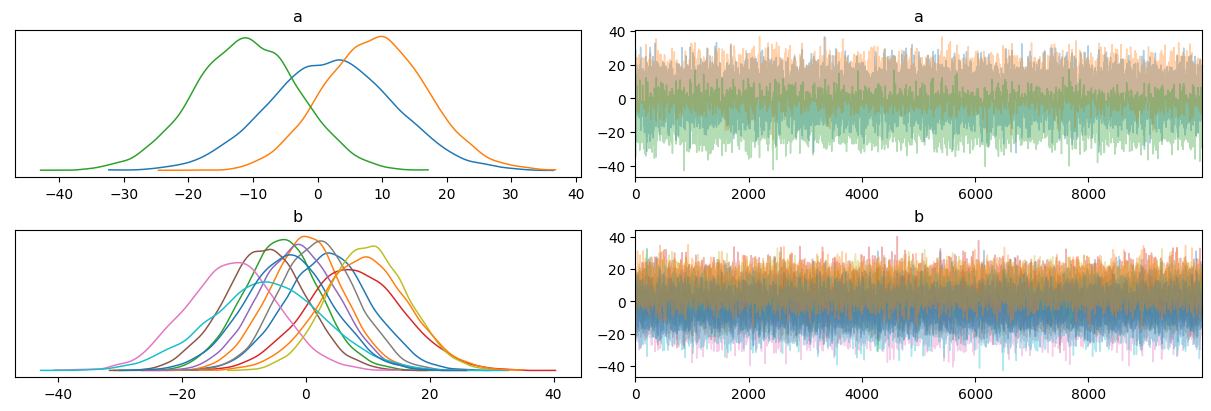

In [76]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['a', 'b']);

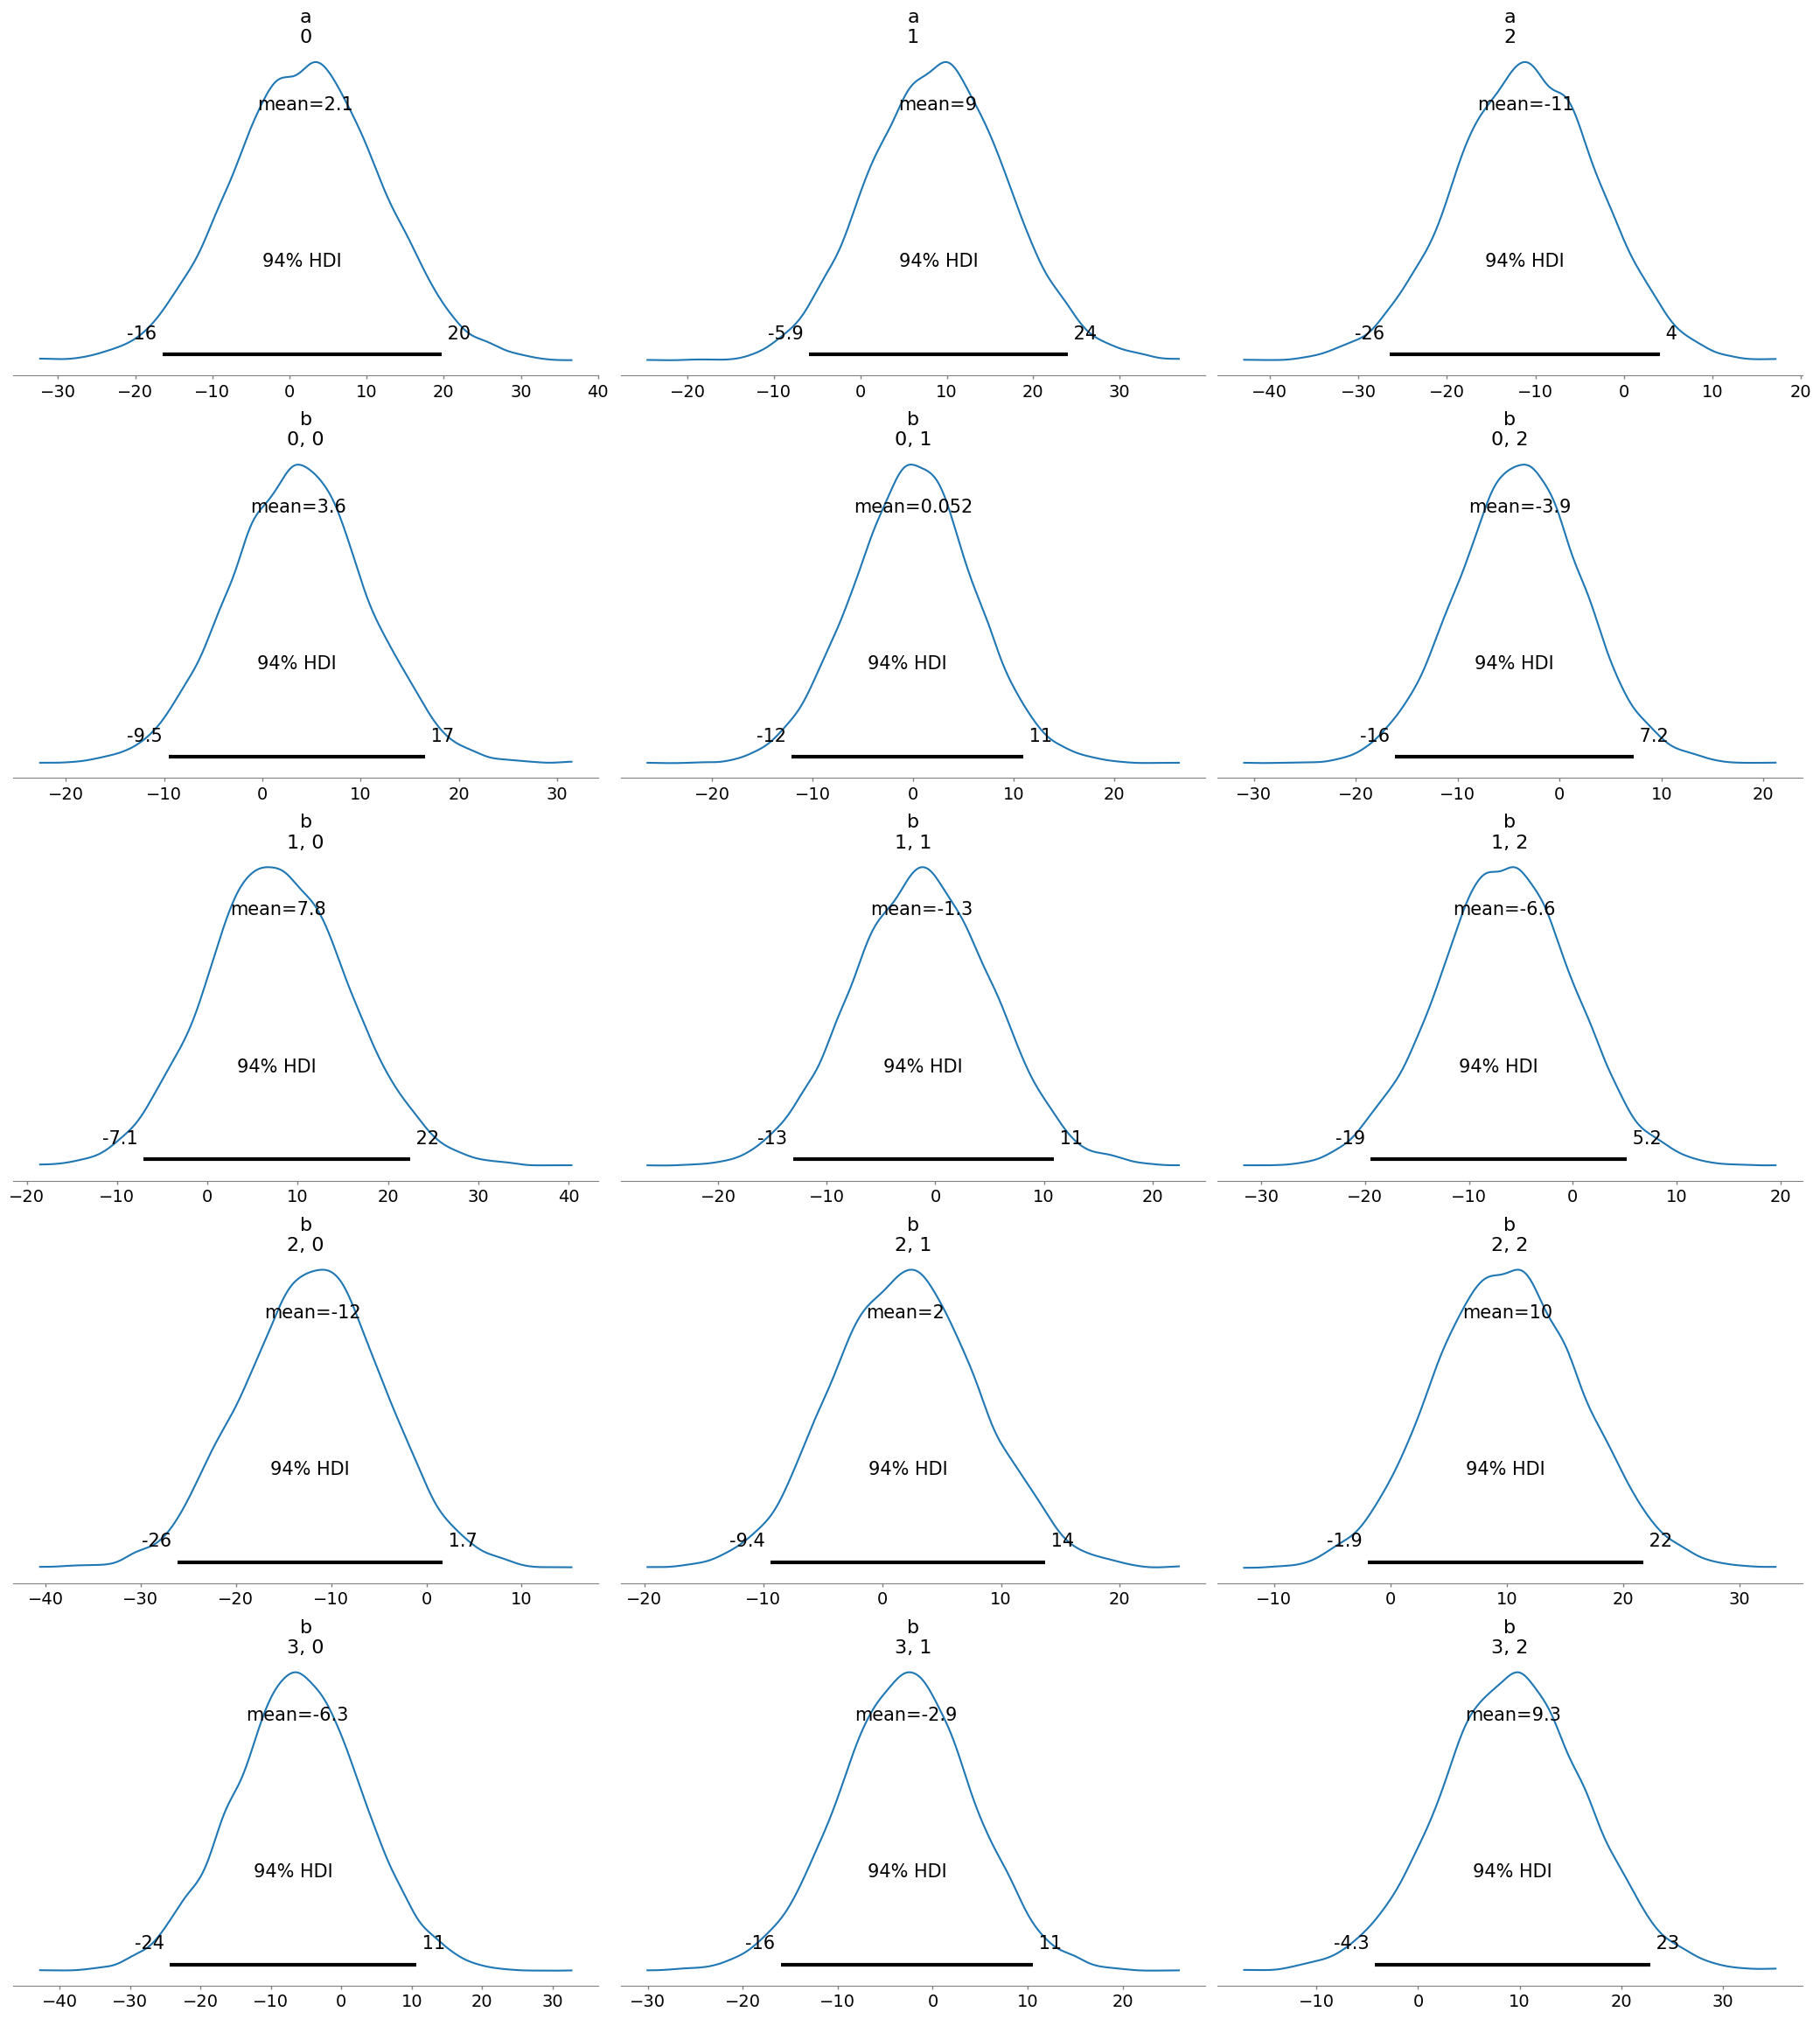

In [77]:
arviz.plot_posterior(azdata, var_names=['a', 'b']);

In [78]:
print(feature_names)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


## Prediction

In [79]:
predictive = Predictive(model, posterior_samples=mcmc.get_samples())

In [80]:
d = x[0:1, :]  # the first data
d

array([[5.1, 3.5, 1.4, 0.2]])

In [81]:
pred = predictive(rng_key=jax.random.PRNGKey(0), x=d)

In [82]:
pred

{'probs': DeviceArray([[[9.9999726e-01, 2.7297901e-06, 4.1573294e-33]],
 
              [[9.9999952e-01, 4.3191073e-07, 9.5927410e-34]],
 
              [[1.0000000e+00, 1.4339646e-15, 5.9024331e-36]],
 
              ...,
 
              [[1.0000000e+00, 9.2810009e-09, 2.1633899e-35]],
 
              [[1.0000000e+00, 4.3920796e-08, 3.1992822e-21]],
 
              [[9.9999988e-01, 6.4832768e-08, 1.2025228e-22]]],            dtype=float32),
 'y': DeviceArray([[0],
              [0],
              [0],
              ...,
              [0],
              [0],
              [0]], dtype=int32)}

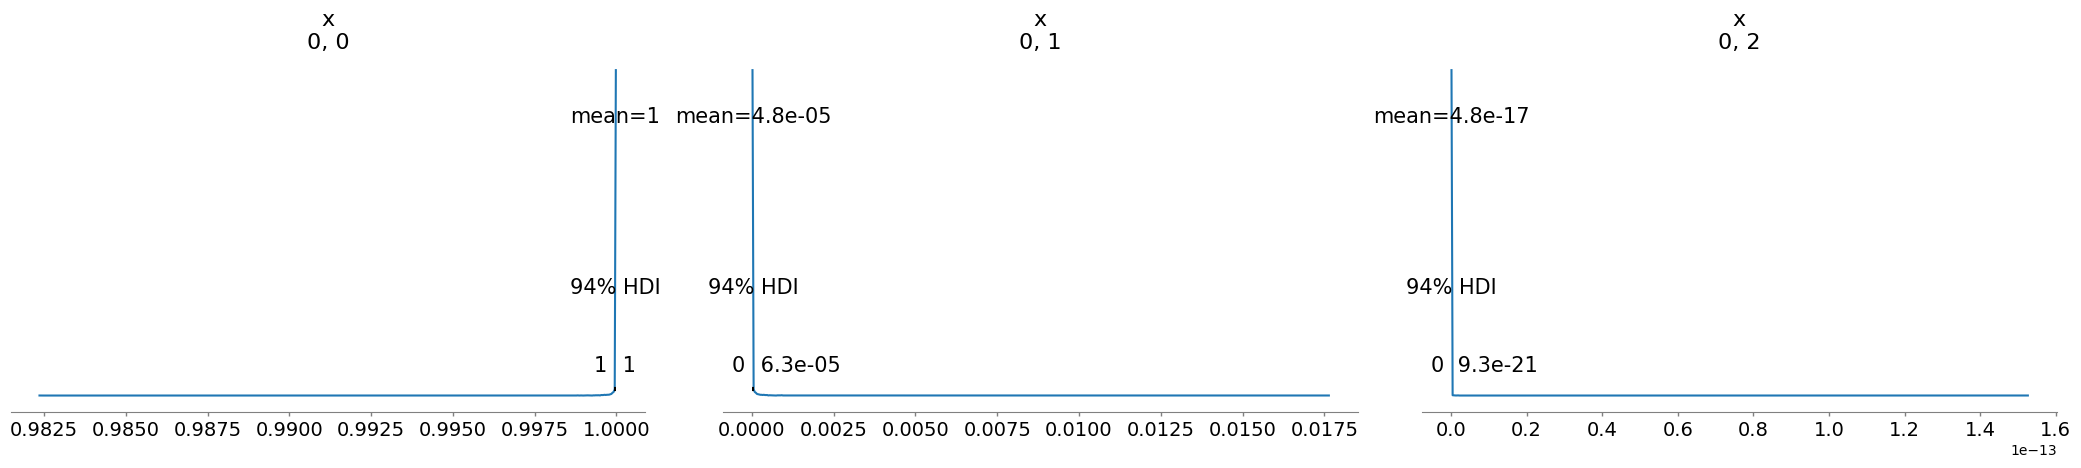

In [83]:
arviz.plot_posterior(np.array( jnp.expand_dims(pred['probs'], 0)) );

### another data

In [84]:
d = x[100, :]  # 
d

array([6.3, 3.3, 6. , 2.5])

In [85]:
pred = predictive(rng_key=jax.random.PRNGKey(0), x=d)

In [86]:
pred

{'probs': DeviceArray([[9.0524022e-29, 9.1083624e-10, 1.0000000e+00],
              [4.0547142e-21, 1.4335541e-08, 1.0000000e+00],
              [3.6394753e-30, 1.7542183e-07, 9.9999988e-01],
              ...,
              [2.4326294e-31, 1.1818501e-09, 1.0000000e+00],
              [5.1280066e-30, 1.8060240e-05, 9.9998188e-01],
              [1.7591122e-26, 7.3265460e-07, 9.9999928e-01]],            dtype=float32),
 'y': DeviceArray([[2, 2, 2, 2],
              [2, 2, 2, 2],
              [2, 2, 2, 2],
              ...,
              [2, 2, 2, 2],
              [2, 2, 2, 2],
              [2, 2, 2, 2]], dtype=int32)}

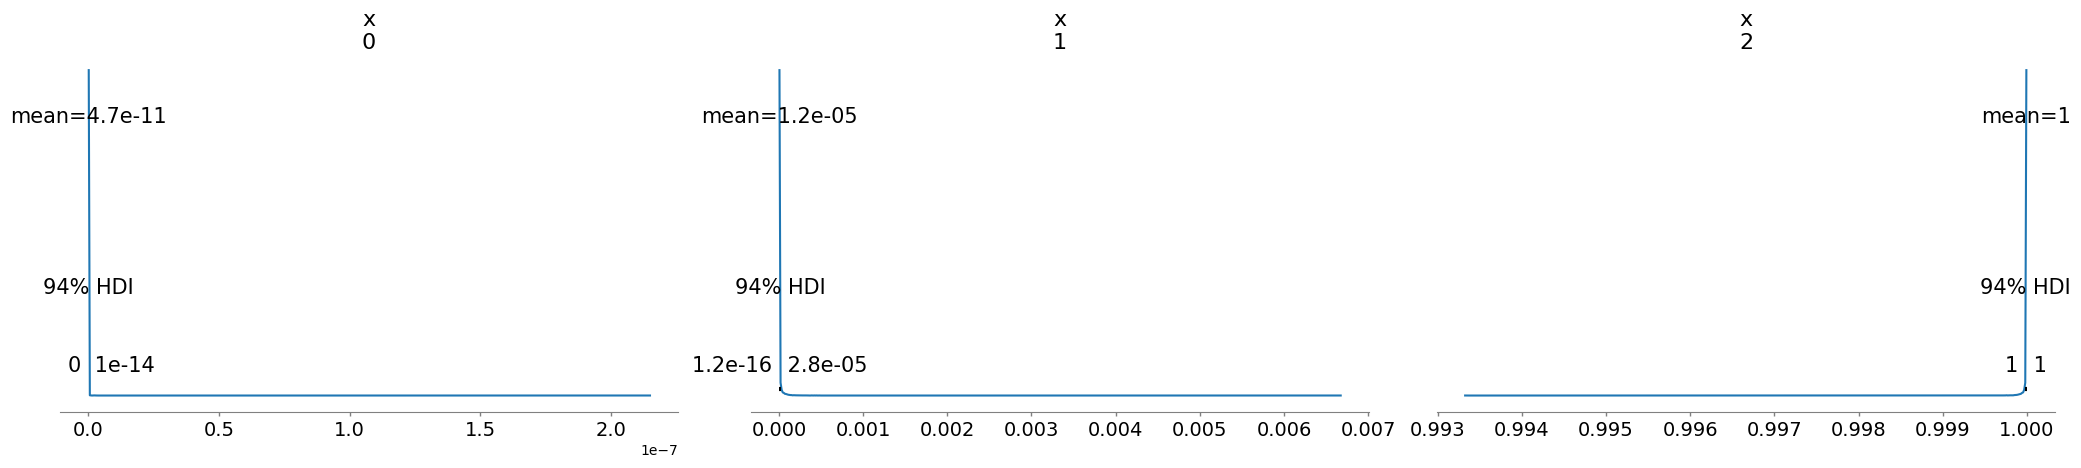

In [87]:
arviz.plot_posterior(np.array( jnp.expand_dims(pred['probs'], 0)) );

# Categorical Regression using Two Features only
- Good to visualize the feature space classifcation (feature map)
    - probabilistic feature map
    - hard threshold
- See the entropy plot
    - uncertain area corresponds to high values of entropy
    

In [88]:
def model_2(x, y=None):
    # simple linear model
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(3,))  # bias/intercept, three species
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(2,3))
#    print(b.shape)
    
    with numpyro.plate(f'y:{x.shape[0]}', size=x.shape[0]):  ## observation
        t = a + jnp.dot(x, b)
        probs = numpyro.deterministic('probs', jax.nn.softmax(t))  ## probs by softmax
        obs = numpyro.sample('y', dist.Categorical(logits=t), obs=y)       
#        print(t.shape, obs.shape, probs.shape)

In [89]:
args = dict(x=x[:,:2], y=y)  # use (sepal length, sepal width)
mcmc = mcmcinf(model_2, args)

sample: 100%|██████████| 11000/11000 [01:03<00:00, 173.34it/s, 1023 steps of size 3.53e-03. acc. prob=0.96]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     13.98      7.78     13.96      3.61     23.49   5429.24      1.00
      a[1]     -0.77      6.51     -0.79     -9.30      7.40   3361.80      1.00
      a[2]    -13.22      6.59    -13.23    -22.43     -5.48   3477.39      1.00
    b[0,0]     -7.49      6.00     -7.48    -15.23     -0.02   3317.67      1.00
    b[0,1]      2.95      5.81      2.85     -5.06      9.79   3267.44      1.00
    b[0,2]      4.77      5.81      4.66     -3.18     11.58   3259.72      1.00
    b[1,0]      8.90      6.39      8.85      0.79     17.11   2856.31      1.00
    b[1,1]     -4.62      6.00     -4.64    -11.80      3.51   2517.46      1.00
    b[1,2]     -4.25      5.99     -4.27    -11.54      3.66   2547.69      1.00

Number of divergences: 0


In [90]:
s = mcmc.get_samples()
s.keys()

dict_keys(['a', 'b', 'probs'])

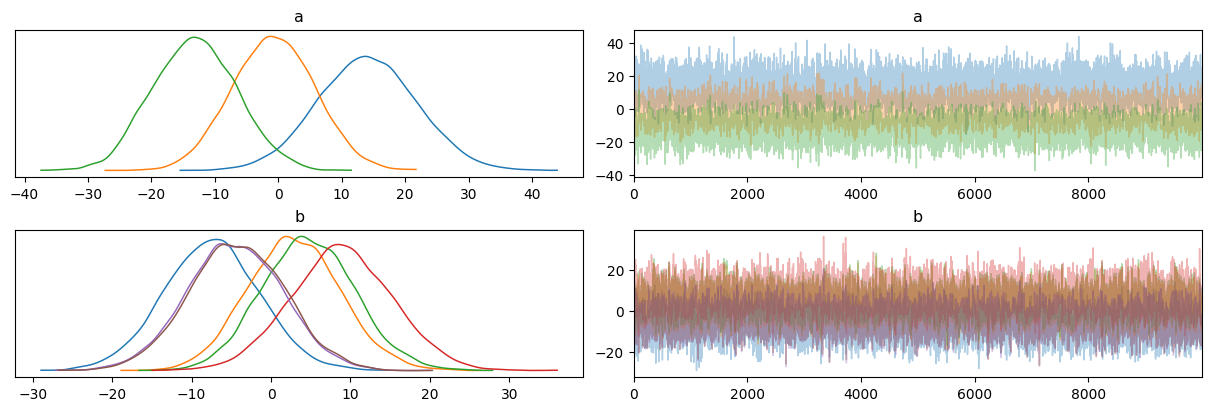

In [91]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['a', 'b']);

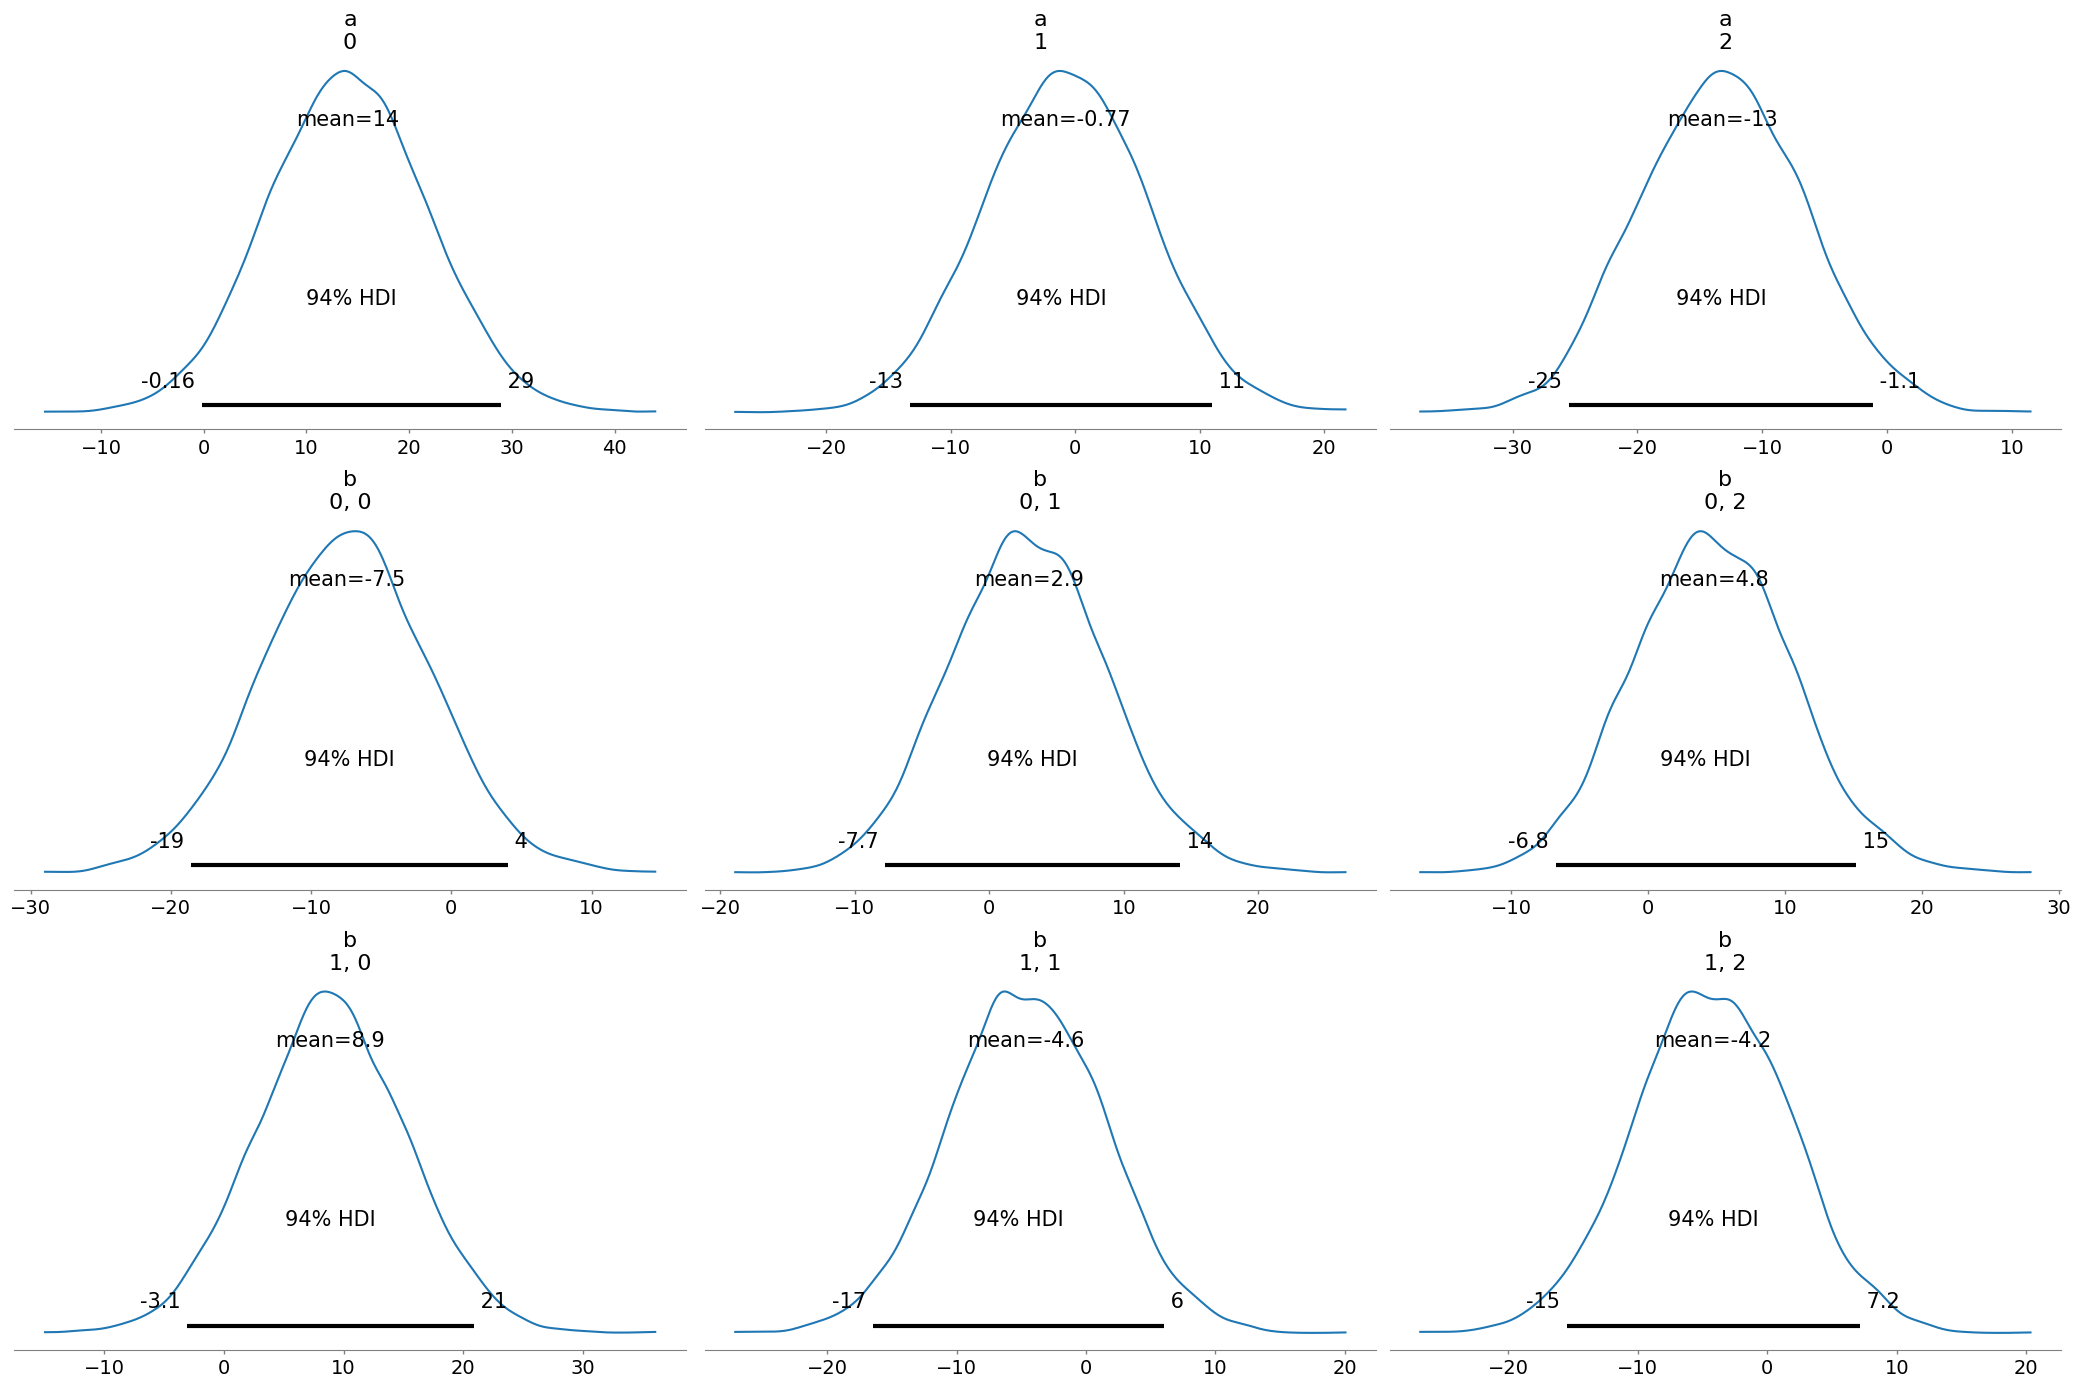

In [92]:
arviz.plot_posterior(azdata, var_names=['a', 'b']);

In [93]:
print(feature_names)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


## Prediction

In [94]:
predictive = Predictive(model_2, posterior_samples=mcmc.get_samples())

In [95]:
d = x[0, :2]  # the first data
d

array([5.1, 3.5])

In [96]:
pred = predictive(rng_key=jax.random.PRNGKey(0), x=d)

In [97]:
pred

{'probs': DeviceArray([[9.9945098e-01, 5.2308885e-04, 2.5914722e-05],
              [9.9946219e-01, 3.5246820e-04, 1.8536394e-04],
              [9.9481648e-01, 4.6532867e-03, 5.3024321e-04],
              ...,
              [9.9997735e-01, 1.9387182e-05, 3.1935765e-06],
              [9.9947482e-01, 4.4636504e-04, 7.8930250e-05],
              [9.9963367e-01, 2.8407821e-04, 8.2259845e-05]],            dtype=float32),
 'y': DeviceArray([[0, 0],
              [0, 0],
              [0, 0],
              ...,
              [0, 0],
              [0, 0],
              [0, 0]], dtype=int32)}

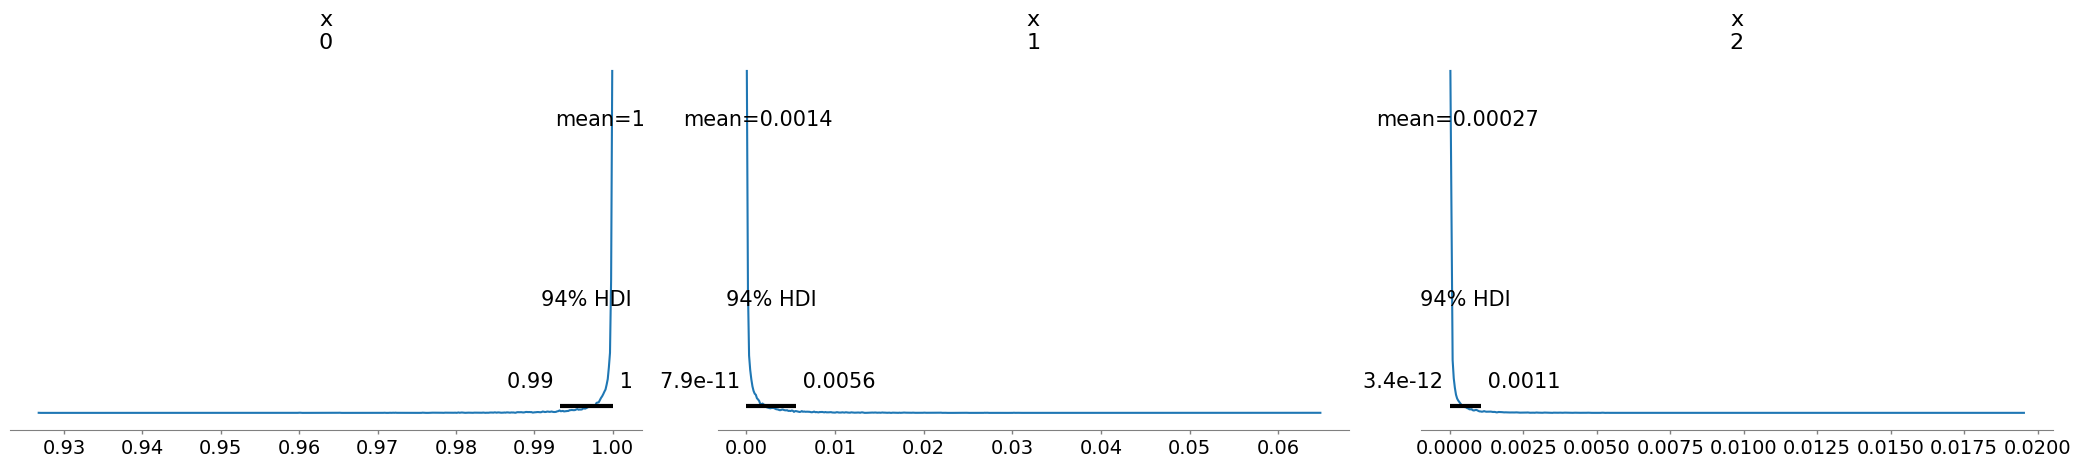

In [98]:
arviz.plot_posterior(np.array( jnp.expand_dims(pred['probs'], 0)) );

### Create a feature map

In [99]:
probs = pred['probs']
print(probs[0])

[9.9945098e-01 5.2308885e-04 2.5914722e-05]


In [100]:
m, M = x.min(0), x.max(0); m, M

(array([4.3, 2. , 1. , 0.1]), array([7.9, 4.4, 6.9, 2.5]))

Grid generation.

- Use `np.meshgrid`: https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
- or just random sample

(15000, 2)


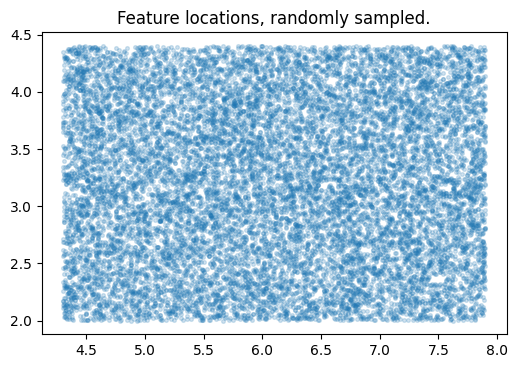

In [101]:
rng = np.random.default_rng(0)
size = 15000
xr = np.c_[rng.uniform(m[0], M[0], size=size), rng.uniform(m[1], M[1], size=size)]
print(xr.shape)
plt.scatter(xr[:,0], xr[:,1], alpha=.2, s=7); plt.title('Feature locations, randomly sampled.');

In [102]:
pr = predictive(rng_key=jax.random.PRNGKey(0), x=xr)['probs']

In [103]:
pr.shape

(10000, 15000, 3)

Let's make a mean probability

In [104]:
mp = pr.mean(0); mp.shape, mp[:2]

((15000, 3),
 DeviceArray([[3.8494133e-07, 3.8616660e-01, 6.1383301e-01],
              [1.3978012e-02, 8.4482658e-01, 1.4119537e-01]],            dtype=float32))

In [105]:
classid = np.argmax(mp, axis=1)
classid

DeviceArray([2, 1, 0, ..., 2, 0, 0], dtype=int32)

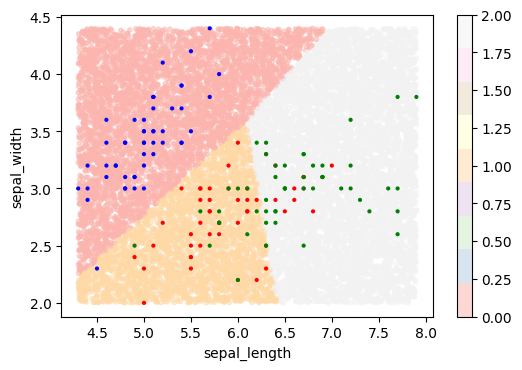

In [106]:
plt.scatter(xr[:,0], xr[:,1], alpha=.51, s=9, cmap='Pastel1', c=classid);
plt.colorbar();
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1]);

colors = np.array(['b', 'r', 'g'])
plt.scatter(x[:,0], x[:,1], s=4, c=colors[y]);

Entropy Map

In [107]:
def entropy(probs):
#    e = -np.sum([p * np.log(p) for p in probs])
    m = -np.log2(probs) * probs
    e = m.sum(axis=1 if len(m.shape) >= 2 else 0)
    return e

In [115]:
entropy([0.98, 0.01, 0.01])

0.16144054254182066

In [109]:
entropy([1/3, 1/3, 1/3])

1.584962500721156

In [110]:
entropy([1/2, 1/2])

1.0

In [116]:
p=0.3  # Prob[X=1]
entropy([1-p, p])

0.8812908992306927

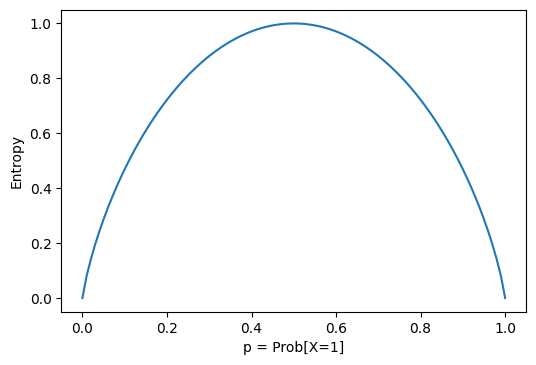

In [126]:
p = np.linspace(0.00001, 1-0.00001, 100)
q = 1 - p
prob = np.c_[q, p]
ent = entropy(prob); ent.shape
plt.plot(p, ent, '-');
plt.xlabel('p = Prob[X=1]'); plt.ylabel('Entropy');

- With uniform distribution, the entropy is equal to the number of bits required to represent the symbols. 
- The unit of the entropy with log2 is 'bit'.

In [111]:
for n in [2, 4, 8, 16, 32, 1024]:
    print(f'n: {n:4}, p= 1./{n:4},  entropy={entropy([1./n for _ in range(n)])} bit(s)')

n:    2, p= 1./   2,  entropy=1.0 bit(s)
n:    4, p= 1./   4,  entropy=2.0 bit(s)
n:    8, p= 1./   8,  entropy=3.0 bit(s)
n:   16, p= 1./  16,  entropy=4.0 bit(s)
n:   32, p= 1./  32,  entropy=5.0 bit(s)
n: 1024, p= 1./1024,  entropy=10.0 bit(s)


In [112]:
probs = pred['probs']
print(probs[0])
entropy(probs[0])

[9.9945098e-01 5.2308885e-04 2.5914722e-05]


DeviceArray(0.00688869, dtype=float32)

In [113]:
ent = entropy(mp)
ent.shape, ent

((15000,),
 DeviceArray([9.6228957e-01, 6.9040662e-01, 1.3325671e-05, ...,
              8.2929552e-01, 3.8332790e-03, 1.1221323e+00], dtype=float32))

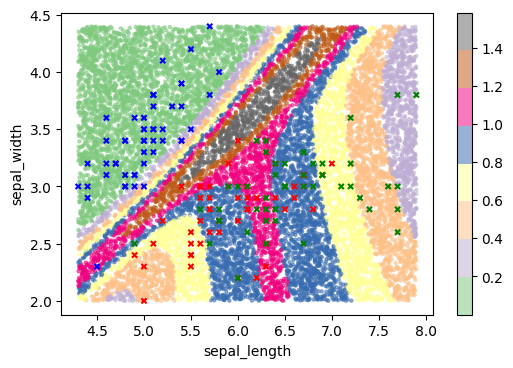

In [114]:
colors = np.array(['b', 'r', 'g'])
plt.scatter(xr[:,0], xr[:,1], alpha=.52, s=5, cmap='Accent', c=ent);  # entropy map
plt.colorbar();
plt.scatter(x[:,0], x[:,1], s=14, c=colors[y], marker='x')  # training data
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1]);

End.